# PyTorch Layer 이해하기

# 예제 불러오기

In [11]:
import torch
from torchvision import datasets, transforms

In [12]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [13]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../dataset/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=1)

In [14]:
image, label = next(iter(train_loader))

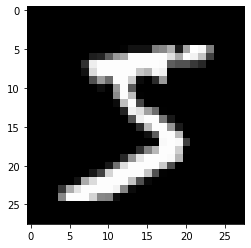

In [15]:
plt.imshow(image[0, 0, :, :],'gray')
plt.show()

# 각 Layer별 설명

- Network 쌓기 위한 준비

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### Convolution

- in_channels: 받게 될 channel의 갯수
- out_channels: 보내고 싶은 channel의 갯수  
- kernel_size: 만들고 싶은 kernel(weights)의 사이즈

In [18]:
nn.Conv2d(in_channels=1,
          out_channels=20,
          kernel_size=5,
          stride=1)

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

In [19]:
layer = nn.Conv2d(1, 20, 5, 1).to(torch.device(
'cpu'))
layer

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

- weight 시각화를 위해 slice하고 numpy화

In [28]:
weight = layer.weight
weight.shape

torch.Size([20, 1, 5, 5])

- 여기서 weight는 학습 가능한 상태이기 때문에 바로 numpy로 뽑아낼 수 없음
- detach() method는 그래프에서 잠깐 빼서 gradient에 영향을 받지 않게 함

In [29]:
weight = weight.detach().numpy()
type(weight)

numpy.ndarray

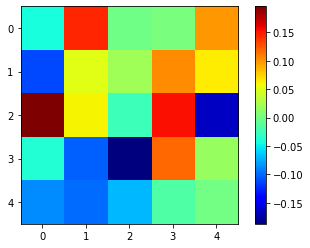

In [34]:
plt.imshow(weight[0, 0, :, :], 'jet')
plt.colorbar()
plt.show()

- output 시각화 준비를 위해 numpy화

In [48]:
output_data = layer(image)
output_data = output_data.data
output = output_data.numpy()
output.shape

(1, 20, 24, 24)

- Input으로 들어간 이미지 numpy화 

In [49]:
image_arr = image.numpy()
image_arr.shape

(1, 1, 28, 28)

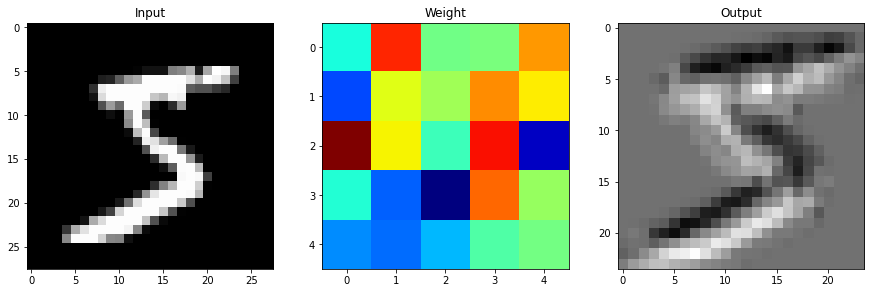

In [52]:
plt.figure(figsize = (15, 30))
plt.subplot(131)
plt.title('Input')
plt.imshow(np.squeeze(image_arr), 'gray')
plt.subplot(132)
plt.title('Weight')
plt.imshow(weight[0, 0, :, :], 'jet')
plt.subplot(133)
plt.title('Output')
plt.imshow(output[0, 0, :, :], 'gray')
plt.show()

### Pooling

input을 먼저 앞에 넣고, 뒤에 kernel 사이즈와 stride를 순서대로 넣음

In [54]:
image.shape

torch.Size([1, 1, 28, 28])

In [55]:
pool = F.max_pool2d(image, 2, 2)
pool.shape

torch.Size([1, 1, 14, 14])

- MaxPool Layer는 weight가 없기 때문에 바로 numpy()가 가능

In [56]:
pool_arr = pool.numpy()
pool_arr.shape

(1, 1, 14, 14)

In [57]:
image_arr.shape

(1, 1, 28, 28)

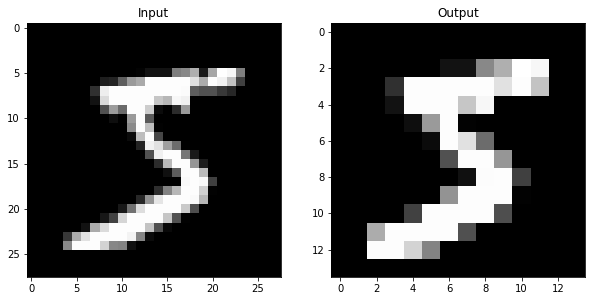

In [59]:
plt.figure(figsize=(10,15))
plt.subplot(121)
plt.title('Input')
plt.imshow(np.squeeze(image_arr), 'gray')
plt.subplot(122)
plt.title('Output')
plt.imshow(np.squeeze(pool_arr), 'gray')
plt.show()

### Linear

nn.Linear는 2d가 아닌 1d만 들어가기 때문에 .view() 1D로 펼쳐줘야함

In [69]:
image.shape

torch.Size([1, 1, 28, 28])

In [70]:
flatten = image.view(1, 28 * 28)
flatten.shape

torch.Size([1, 784])

In [71]:
lin = nn.Linear(784, 10)(flatten)
lin.shape

torch.Size([1, 10])

In [72]:
lin

tensor([[-0.5502,  0.0943, -0.0298, -0.0332, -0.2757,  0.0418,  0.0087,  0.1796,
         -0.2342, -0.1318]], grad_fn=<AddmmBackward>)

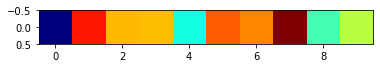

In [73]:
plt.imshow(lin.detach().numpy(), 'jet')
plt.show()

### Softmax

결과를 numpy로 꺼내기 위해선 weight가 담긴 Linear에 weight를 꺼줘야함

In [151]:
with torch.no_grad():
    flatten = image.view(1, 28*28)
    lin = nn.Linear(784, 10)(flatten)
    softmax = F.softmax(lin, dim=1)
softmax

tensor([[0.0929, 0.1083, 0.0673, 0.1496, 0.0728, 0.0882, 0.0937, 0.0865, 0.1359,
         0.1047]])

In [152]:
np.sum(softmax.numpy())

1.0

# Layer 쌓기

예제 출처: https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#id23

nn 과 nn.functional의 차이점
- nn은 학습 파라미터가 담긴 것 
- nn.functional은 학습 파라미터가 없는 것이라 생각하면 간단

In [160]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        # Feature Extraction
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
#         print(x.shape)
        # Fully Connected(Classification)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [162]:
model = Net()

result = model.forward(image)
result

tensor([[-2.2885, -2.2862, -2.2894, -2.2569, -2.3260, -2.3493, -2.3610, -2.3151,
         -2.2190, -2.3434]], grad_fn=<LogSoftmaxBackward>)

In [164]:
model

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)